In [1075]:
import sys
import os

current_dir = os.getcwd()  # dir corrente
root_path = os.path.abspath(os.path.join(current_dir, '..')) # path per dir principale
sys.path.append(root_path)

from imports import *


In [1076]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [1077]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_complete.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_complete.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
df_labels_test = pd.read_csv(f"{path_dataframes}/df_labels_test.csv")

In [1078]:
df_labels_test

,index,Case,Spacecraft
0,0,178,1
1,1,179,1
2,2,180,1
3,3,181,1
4,4,182,1
5,5,183,1
6,6,184,1
7,7,185,1
8,8,186,1
9,9,187,1


In [1079]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [1080]:
column_to_number = {
    'SV1': 1,
    'SV2': 2,
    'SV3': 3,
    'SV4': 4,
}

df_labels['fault_sv'] = 0
df_labels['opening_ratio'] = 100


for index, row in df_labels.iterrows():
    for col in column_to_number.keys():
        if row[col] < 100:
            val=row[col]
            df_labels.at[index, 'fault_sv'] = column_to_number[col]
            df_labels.at[index,'opening_ratio'] = [val]
            break



In [1081]:
df_labels.head(5)

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100


In [1082]:
df_normal = df_train[:106]
df_fault=df_train[105:153]

df_labels=df_labels[105:153]
df_train=df_train[105:153]

In [1083]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0
110,110,111,1,2,100,25,100,100,0,0,0,0,0,0,0,0,1,2,25
111,111,112,1,2,100,50,100,100,0,0,0,0,0,0,0,0,1,2,50
112,112,113,1,2,100,75,100,100,0,0,0,0,0,0,0,0,1,2,75
113,113,114,1,2,100,100,0,100,0,0,0,0,0,0,0,0,1,3,0
114,114,115,1,2,100,100,25,100,0,0,0,0,0,0,0,0,1,3,25


In [1084]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
105,105,0.052357,0.654635,0.351878,0.315838,0.647224,0.439810,0.668211,0.785405,0.449112,...,0.317209,0.578535,0.563078,0.249533,0.509906,1.0,0.249533,0.545152,0.657535,0.522463
106,106,0.867260,0.855489,0.917812,0.266160,0.681149,0.356433,0.927012,0.487642,0.402322,...,0.548534,0.668887,0.671507,0.467184,0.621233,0.8,0.467184,0.734110,0.585896,0.321131
107,107,0.861705,0.875727,0.897897,0.283671,0.653145,0.434774,0.902716,0.468960,0.388470,...,0.498982,0.548327,0.550601,0.417742,0.491155,0.8,0.417742,0.643648,0.492519,0.447587
108,108,0.859533,0.847921,0.886049,0.294589,0.635187,0.412508,0.899782,0.456635,0.379678,...,0.533284,0.595139,0.597513,0.451797,0.541409,0.8,0.451797,0.690104,0.517903,0.041597
109,109,0.097322,0.665730,0.233585,0.345146,0.618351,0.705987,0.174339,0.868056,0.412636,...,0.285040,0.561699,0.545182,0.221797,0.492568,0.8,0.221797,0.490784,0.664656,0.049917
110,110,0.861230,0.947341,0.872779,0.285523,0.660740,0.358421,0.860933,0.485819,0.393010,...,0.515639,0.646134,0.647799,0.434183,0.594941,0.8,0.434183,0.685885,0.585853,0.740433
111,111,0.851430,0.954126,0.879892,0.291472,0.647887,0.354309,0.873410,0.468076,0.389228,...,0.502679,0.621939,0.623321,0.421375,0.567667,0.8,0.421375,0.670359,0.568315,0.231281
112,112,0.848011,0.957580,0.888437,0.291415,0.648048,0.372016,0.872421,0.462917,0.391166,...,0.650151,0.692083,0.698937,0.573742,0.654291,0.8,0.573742,0.843473,0.537719,0.562396
113,113,0.105846,0.565080,0.248407,0.388752,0.601374,0.795180,0.282319,0.753161,0.430740,...,0.354188,0.625479,0.616626,0.282146,0.573530,1.0,0.282146,0.535575,0.698453,0.688852
114,114,0.833727,0.821017,0.882332,0.284824,0.670706,0.492722,0.715636,0.484853,0.406980,...,0.586591,0.623041,0.628486,0.506262,0.572243,0.8,0.506262,0.755976,0.508105,0.575707


In [1085]:
df_train.head(10)

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
105,105,0.052357,0.654635,0.351878,0.315838,0.647224,0.439810,0.668211,0.785405,0.449112,...,0.317209,0.578535,0.563078,0.249533,0.509906,1.0,0.249533,0.545152,0.657535,0.522463
106,106,0.867260,0.855489,0.917812,0.266160,0.681149,0.356433,0.927012,0.487642,0.402322,...,0.548534,0.668887,0.671507,0.467184,0.621233,0.8,0.467184,0.734110,0.585896,0.321131
107,107,0.861705,0.875727,0.897897,0.283671,0.653145,0.434774,0.902716,0.468960,0.388470,...,0.498982,0.548327,0.550601,0.417742,0.491155,0.8,0.417742,0.643648,0.492519,0.447587
108,108,0.859533,0.847921,0.886049,0.294589,0.635187,0.412508,0.899782,0.456635,0.379678,...,0.533284,0.595139,0.597513,0.451797,0.541409,0.8,0.451797,0.690104,0.517903,0.041597
109,109,0.097322,0.665730,0.233585,0.345146,0.618351,0.705987,0.174339,0.868056,0.412636,...,0.285040,0.561699,0.545182,0.221797,0.492568,0.8,0.221797,0.490784,0.664656,0.049917
110,110,0.861230,0.947341,0.872779,0.285523,0.660740,0.358421,0.860933,0.485819,0.393010,...,0.515639,0.646134,0.647799,0.434183,0.594941,0.8,0.434183,0.685885,0.585853,0.740433
111,111,0.851430,0.954126,0.879892,0.291472,0.647887,0.354309,0.873410,0.468076,0.389228,...,0.502679,0.621939,0.623321,0.421375,0.567667,0.8,0.421375,0.670359,0.568315,0.231281
112,112,0.848011,0.957580,0.888437,0.291415,0.648048,0.372016,0.872421,0.462917,0.391166,...,0.650151,0.692083,0.698937,0.573742,0.654291,0.8,0.573742,0.843473,0.537719,0.562396
113,113,0.105846,0.565080,0.248407,0.388752,0.601374,0.795180,0.282319,0.753161,0.430740,...,0.354188,0.625479,0.616626,0.282146,0.573530,1.0,0.282146,0.535575,0.698453,0.688852
114,114,0.833727,0.821017,0.882332,0.284824,0.670706,0.492722,0.715636,0.484853,0.406980,...,0.586591,0.623041,0.628486,0.506262,0.572243,0.8,0.506262,0.755976,0.508105,0.575707


In [1086]:
df_labels.head(5)

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0


In [1087]:
df_train["sv"] = df_labels["fault_sv"]

In [1088]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [1089]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [1090]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [1091]:
df_train=df_train.drop(columns="index")

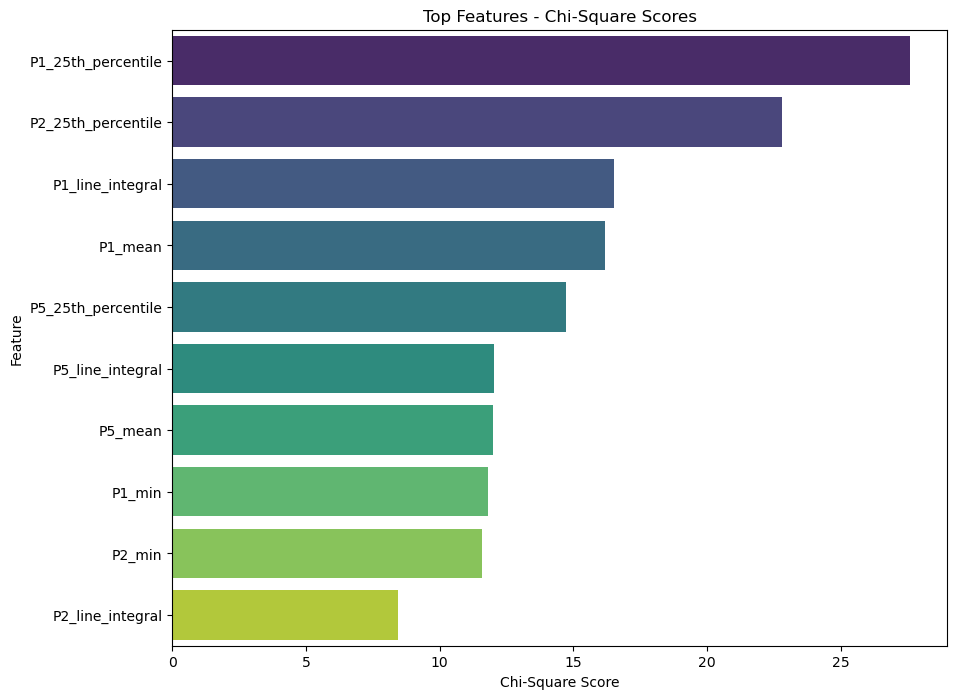

In [1092]:
features_chi2 = feature_selection_chi2(df_train,df_labels["opening_ratio"],10)


df_train = df_train[features_chi2]
df_test = df_test[features_chi2]

In [1093]:
from scipy.stats import pearsonr

In [1094]:
plt.figure(figsize=(14,8))
correlations = []
for column in df_train.columns:
    corr, p_value = pearsonr(df_labels['opening_ratio'], df_train[column])
    correlations.append((column, corr, p_value))

correlation_df = pd.DataFrame(correlations, columns=['Column', 'Correlation', 'P-value'])
sorted_correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)
# print(correlation_df)
print(sorted_correlation_df)

correlation_matrix = df_train.corrwith(df_labels['opening_ratio']).to_frame().T
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()


               Column  Correlation       P-value
8              P2_min    -0.573881  2.004876e-05
9    P2_line_integral    -0.671363  1.761682e-07
7              P1_min    -0.737157  2.304863e-09
4  P5_25th_percentile    -0.758784  4.138854e-10
3             P1_mean    -0.759074  4.039747e-10
2    P1_line_integral    -0.759104  4.029543e-10
1  P2_25th_percentile    -0.763973  2.668840e-10
6             P5_mean    -0.765671  2.306176e-10
5    P5_line_integral    -0.765767  2.287271e-10
0  P1_25th_percentile    -0.773289  1.179680e-10


<Figure size 1400x800 with 0 Axes>

In [1095]:
with open(f'{path_dataframes}/index_test_normal_task1.pkl', 'rb') as file:
    idx_normal_test = pickle.load(file)

with open(f'{path_dataframes}/index_test_fault_task2.pkl', 'rb') as file:
    idx_fault_test = pickle.load(file)



In [1096]:
idx_fault_test

array([179, 188, 190, 202, 205, 211, 212, 214])

In [1097]:
idx_normal_test

array([180, 181, 182, 183, 185, 187, 189, 191, 194, 195, 198, 199, 201,
       203, 206, 208, 210, 213, 215, 217, 220, 223])

In [1098]:
df_test.tail(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
41,0.137813,0.139849,0.075636,0.079810,0.239268,0.088482,0.088664,0.749174,0.040168,0.238118
42,-0.001589,0.078986,0.151735,0.156040,0.158852,0.141463,0.141661,0.162941,0.013035,0.224217
43,0.188521,0.035716,0.098472,0.101479,0.230726,0.004234,0.003483,0.376553,1.000000,0.191428
44,24.928596,17.360565,128.228089,127.780700,15.599159,86.648854,86.774605,1.620264,1.285239,67.511830
45,0.008673,0.080818,0.151436,0.155722,0.157655,0.131874,0.132045,0.161952,0.013266,0.207286


In [1099]:
new_index = range(178, 178 + len(df_test))

df_test.set_index(pd.Index(new_index), inplace=True)

df_labels_test.set_index(pd.Index(new_index), inplace=True)



In [1100]:
df_labels_test

,index,Case,Spacecraft
178,0,178,1
179,1,179,1
180,2,180,1
181,3,181,1
182,4,182,1
183,5,183,1
184,6,184,1
185,7,185,1
186,8,186,1
187,9,187,1


In [1101]:
df_test

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
178,0.188521,0.039488,0.079321,0.082119,0.251141,0.055201,0.054306,0.371555,0.892153,0.218569
179,0.063933,0.046077,0.143726,0.147686,0.174802,0.130994,0.131273,0.182168,0.007976,0.351138
180,0.065567,0.056646,0.148848,0.152884,0.176327,0.069548,0.069689,0.152192,0.014128,0.176715
181,0.061874,0.042924,0.152639,0.156664,0.169909,0.186084,0.186267,0.162786,0.014086,0.178976
182,0.065674,0.056385,0.146502,0.150548,0.179430,0.071468,0.071635,0.152803,0.014132,0.182215
183,0.064793,0.058526,0.138308,0.142371,0.176327,0.077004,0.077192,0.152057,0.014342,0.178901
184,25.221792,17.693374,128.022406,127.576711,15.878233,86.454785,86.581226,1.861598,1.726244,67.370615
185,0.068747,0.059840,0.137160,0.141229,0.179970,0.102089,0.102284,0.152060,0.014342,0.175463
186,0.032575,0.162470,0.052874,0.052536,0.200950,0.156484,0.150024,0.307737,0.036904,0.213790
187,0.065113,0.053632,0.141022,0.145077,0.179866,0.134594,0.134792,0.152046,0.014222,0.181163


In [1102]:

df_test_normal = df_test.loc[idx_normal_test]
df_test_fault = df_test.loc[idx_fault_test]

In [1103]:
df_test_normal.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
180,0.065567,0.056646,0.148848,0.152884,0.176327,0.069548,0.069689,0.152192,0.014128,0.176715
181,0.061874,0.042924,0.152639,0.156664,0.169909,0.186084,0.186267,0.162786,0.014086,0.178976
182,0.065674,0.056385,0.146502,0.150548,0.179430,0.071468,0.071635,0.152803,0.014132,0.182215
183,0.064793,0.058526,0.138308,0.142371,0.176327,0.077004,0.077192,0.152057,0.014342,0.178901
185,0.068747,0.059840,0.137160,0.141229,0.179970,0.102089,0.102284,0.152060,0.014342,0.175463


In [1104]:
df_test_fault.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
179,0.063933,0.046077,0.143726,0.147686,0.174802,0.130994,0.131273,0.182168,0.007976,0.351138
188,0.042952,0.085695,0.087379,0.091408,0.204735,0.115434,0.115677,-0.172830,0.029750,0.183992
190,0.054671,0.050078,0.145353,0.149378,0.174555,0.189345,0.189514,0.155755,0.013683,0.192159
202,0.013957,0.073382,0.126740,0.131129,0.157568,0.149770,0.149924,0.167160,0.013006,0.210638
205,0.005313,0.067720,0.146665,0.150984,0.157479,0.156141,0.156330,0.165093,0.012307,0.165006


In [1105]:
df_fault.shape[0]

48

In [1106]:
def calculate_average_dtw(anomalous_vector, normal_vectors):
    distances = []
    for normal_vector in normal_vectors:
        distance, _ = fastdtw(anomalous_vector.reshape(-1, 1), normal_vector.reshape(-1, 1), dist=euclidean)
        distances.append(distance)
    return np.mean(distances)


In [1107]:

# dtw_train = []

# for i in range(df_fault.shape[0]):
#     anomalous_vector = df_fault.iloc[i].values
#     normal_vectors = [df_normal.iloc[j].values for j in range(df_normal.shape[0])]
#     avg_distance = calculate_average_dtw(anomalous_vector, normal_vectors)
#     dtw_train.append(avg_distance)

In [1108]:
# df_test_fault.shape[0]

In [1109]:
# df_fault.shape[0]

In [1110]:
# dtw_test=[]
# for i in range(df_test_fault.shape[0]):
#     anomalous_vector = df_test_fault.iloc[i].values
#     normal_vectors = [df_test_normal.iloc[j].values for j in range(df_test_normal.shape[0])]
#     avg_distance = calculate_average_dtw(anomalous_vector, normal_vectors)
#     dtw_test.append(avg_distance)

In [1111]:
# dtw_test

In [1112]:
# df_fault["dtw"] = dtw_train
# df_test_fault["dtw"] = dtw_test

In [1113]:
df_fault

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
105,105,0.052357,0.654635,0.351878,0.315838,0.647224,0.439810,0.668211,0.785405,0.449112,...,0.317209,0.578535,0.563078,0.249533,0.509906,1.0,0.249533,0.545152,0.657535,0.522463
106,106,0.867260,0.855489,0.917812,0.266160,0.681149,0.356433,0.927012,0.487642,0.402322,...,0.548534,0.668887,0.671507,0.467184,0.621233,0.8,0.467184,0.734110,0.585896,0.321131
107,107,0.861705,0.875727,0.897897,0.283671,0.653145,0.434774,0.902716,0.468960,0.388470,...,0.498982,0.548327,0.550601,0.417742,0.491155,0.8,0.417742,0.643648,0.492519,0.447587
108,108,0.859533,0.847921,0.886049,0.294589,0.635187,0.412508,0.899782,0.456635,0.379678,...,0.533284,0.595139,0.597513,0.451797,0.541409,0.8,0.451797,0.690104,0.517903,0.041597
109,109,0.097322,0.665730,0.233585,0.345146,0.618351,0.705987,0.174339,0.868056,0.412636,...,0.285040,0.561699,0.545182,0.221797,0.492568,0.8,0.221797,0.490784,0.664656,0.049917
110,110,0.861230,0.947341,0.872779,0.285523,0.660740,0.358421,0.860933,0.485819,0.393010,...,0.515639,0.646134,0.647799,0.434183,0.594941,0.8,0.434183,0.685885,0.585853,0.740433
111,111,0.851430,0.954126,0.879892,0.291472,0.647887,0.354309,0.873410,0.468076,0.389228,...,0.502679,0.621939,0.623321,0.421375,0.567667,0.8,0.421375,0.670359,0.568315,0.231281
112,112,0.848011,0.957580,0.888437,0.291415,0.648048,0.372016,0.872421,0.462917,0.391166,...,0.650151,0.692083,0.698937,0.573742,0.654291,0.8,0.573742,0.843473,0.537719,0.562396
113,113,0.105846,0.565080,0.248407,0.388752,0.601374,0.795180,0.282319,0.753161,0.430740,...,0.354188,0.625479,0.616626,0.282146,0.573530,1.0,0.282146,0.535575,0.698453,0.688852
114,114,0.833727,0.821017,0.882332,0.284824,0.670706,0.492722,0.715636,0.484853,0.406980,...,0.586591,0.623041,0.628486,0.506262,0.572243,0.8,0.506262,0.755976,0.508105,0.575707


In [1114]:
df_train.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311


In [1115]:
# df_train
df_labels.head(5)

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0


In [1116]:
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(
#     df_fault.index, 
#     df_fault["dtw"], 
#     c=df_labels["opening_ratio"],  
#     cmap='viridis',  
#     alpha=0.7 
# )

# cbar = plt.colorbar(scatter)
# cbar.set_label('Opening Ratio')

# unique_spacecraft = df_labels["Spacecraft"].unique()
# for spacecraft in unique_spacecraft:
#     indices = df_labels.index[df_labels["Spacecraft"] == spacecraft].tolist()
#     last_index = indices[-1]  # Get the last index in the list
#     plt.axvline(x=last_index, color='red', linestyle='--', alpha=0.5)

# plt.xlabel('cases')
# plt.ylabel('dtw')
# plt.title('Dtw per spacecraft (opening ration 0,25,50,75)')

# plt.show()

In [1117]:
df_labels_test.head()

,index,Case,Spacecraft
178,0,178,1
179,1,179,1
180,2,180,1
181,3,181,1
182,4,182,1


In [1118]:
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(
#     df_test_fault.index, 
#     df_test_fault["dtw"],
#     cmap='viridis',  
#     alpha=0.7 
# )

# cbar = plt.colorbar(scatter)
# cbar.set_label('Opening Ratio')

# unique_spacecraft = df_labels_test["Spacecraft"].unique()
# for spacecraft in unique_spacecraft:
#     indices = df_labels_test.index[df_labels_test["Spacecraft"] == spacecraft].tolist()
#     last_index = indices[-1]  # Get the last index in the list
#     plt.axvline(x=last_index, color='red', linestyle='--', alpha=0.5)

# plt.xlabel('cases')
# plt.ylabel('dtw')
# plt.title('Dtw per spacecraft (opening ration 0,25,50,75)')

# plt.show()

In [1119]:
df_train.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311


In [1120]:
df_train.head(5)

,P1_25th_percentile,P2_25th_percentile,P1_line_integral,P1_mean,P5_25th_percentile,P5_line_integral,P5_mean,P1_min,P2_min,P2_line_integral
105,0.982800,0.980042,0.947743,0.947643,0.742798,0.589270,0.589128,0.563963,0.636005,0.889589
106,0.059154,0.066443,0.128738,0.132740,0.181802,0.083007,0.083189,0.000000,0.000403,0.000000
107,0.066919,0.070128,0.134247,0.138295,0.164252,0.061677,0.061822,0.079907,0.004243,0.402981
108,0.042085,0.056827,0.136400,0.140467,0.176166,0.115446,0.115649,0.127828,0.006799,0.225642
109,0.986978,1.000000,0.902477,0.902678,0.744361,0.770074,0.770205,0.818104,0.424390,0.939311


In [1121]:
df_labels.head(5)

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
105,105,106,1,2,0,100,100,100,0,0,0,0,0,0,0,0,1,1,0
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0


In [1122]:
df_fault

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_StdPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
105,105,0.052357,0.654635,0.351878,0.315838,0.647224,0.439810,0.668211,0.785405,0.449112,...,0.317209,0.578535,0.563078,0.249533,0.509906,1.0,0.249533,0.545152,0.657535,0.522463
106,106,0.867260,0.855489,0.917812,0.266160,0.681149,0.356433,0.927012,0.487642,0.402322,...,0.548534,0.668887,0.671507,0.467184,0.621233,0.8,0.467184,0.734110,0.585896,0.321131
107,107,0.861705,0.875727,0.897897,0.283671,0.653145,0.434774,0.902716,0.468960,0.388470,...,0.498982,0.548327,0.550601,0.417742,0.491155,0.8,0.417742,0.643648,0.492519,0.447587
108,108,0.859533,0.847921,0.886049,0.294589,0.635187,0.412508,0.899782,0.456635,0.379678,...,0.533284,0.595139,0.597513,0.451797,0.541409,0.8,0.451797,0.690104,0.517903,0.041597
109,109,0.097322,0.665730,0.233585,0.345146,0.618351,0.705987,0.174339,0.868056,0.412636,...,0.285040,0.561699,0.545182,0.221797,0.492568,0.8,0.221797,0.490784,0.664656,0.049917
110,110,0.861230,0.947341,0.872779,0.285523,0.660740,0.358421,0.860933,0.485819,0.393010,...,0.515639,0.646134,0.647799,0.434183,0.594941,0.8,0.434183,0.685885,0.585853,0.740433
111,111,0.851430,0.954126,0.879892,0.291472,0.647887,0.354309,0.873410,0.468076,0.389228,...,0.502679,0.621939,0.623321,0.421375,0.567667,0.8,0.421375,0.670359,0.568315,0.231281
112,112,0.848011,0.957580,0.888437,0.291415,0.648048,0.372016,0.872421,0.462917,0.391166,...,0.650151,0.692083,0.698937,0.573742,0.654291,0.8,0.573742,0.843473,0.537719,0.562396
113,113,0.105846,0.565080,0.248407,0.388752,0.601374,0.795180,0.282319,0.753161,0.430740,...,0.354188,0.625479,0.616626,0.282146,0.573530,1.0,0.282146,0.535575,0.698453,0.688852
114,114,0.833727,0.821017,0.882332,0.284824,0.670706,0.492722,0.715636,0.484853,0.406980,...,0.586591,0.623041,0.628486,0.506262,0.572243,0.8,0.506262,0.755976,0.508105,0.575707


In [1123]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_labels["opening_ratio"], test_size=0.3, random_state=42)


In [1124]:

model_linear = LinearRegression()

model_linear.fit(X_train, y_train)

y_pred_linear = model_linear.predict(X_test)

mae_linear = mean_absolute_error(y_test, y_pred_linear)
print("Mean Absolute Error:", mae_linear)

Mean Absolute Error: 19.42611451425709


In [1125]:
print("y_pred: ", y_pred_linear)
print(" ----------------------------------------------------------------- ")
print("y_test : ", y_test.values)

y_pred:  [ 59.10549527 -13.34718183  50.73654674  62.3514217    2.36920522
  63.14513608 -12.39360616  55.4847559   13.79241609  28.76823739
 -39.66776254  41.496287    53.62495671  45.6463237   77.63095253]
 ----------------------------------------------------------------- 
y_test :  [75  0 50 75  0 25  0 75  0 25  0 75 50 75 25]


In [1126]:
# df_test_fault[["dtw"]]

In [1127]:
pred=model_linear.predict(df_test_fault)

In [1128]:
pred=pred.astype(str)

In [1129]:
df_test_fault["fault_loc_pred"]=pred

In [1130]:
df_test_fault["Case"] = df_test_fault.index


In [1131]:
df_test_fault = df_test_fault[["fault_loc_pred","Case"]]



In [1132]:
df_test_fault

,fault_loc_pred,Case
179,36.42742402735519,179
188,5.135769996449454,188
190,30.460646785111578,190
202,56.19629760470883,202
205,55.237487404120486,205
211,53.054860672658776,211
212,68.77981832842647,212
214,59.15305342609787,214


In [1133]:
df_test_fault

,fault_loc_pred,Case
179,36.42742402735519,179
188,5.135769996449454,188
190,30.460646785111578,190
202,56.19629760470883,202
205,55.237487404120486,205
211,53.054860672658776,211
212,68.77981832842647,212
214,59.15305342609787,214


In [1134]:
df_test_real = pd.read_csv("/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/answer.csv")


In [1135]:
df_test_real = df_test_real[df_test_real["task5"] != 100]

In [1136]:
df_test_real = df_test_real[["task5","ID"]]
df_test_real[["task5","ID"]] = df_test_real[["task5","ID"]].astype(float)

In [1137]:
df_test_real

,task5,ID
1,22.0,179.0
3,76.0,181.0
10,5.0,188.0
12,46.0,190.0
21,98.0,199.0
24,44.0,202.0
27,94.0,205.0
33,95.0,211.0
34,70.0,212.0
36,24.0,214.0


In [1138]:
new_row = pd.DataFrame({
   
    'Case': ['199', '181']
})
df_test_fault = pd.concat([df_test_fault, new_row], ignore_index=True)
df_test_fault

,fault_loc_pred,Case
0,36.42742402735519,179
1,5.135769996449454,188
2,30.460646785111578,190
3,56.19629760470883,202
4,55.237487404120486,205
5,53.054860672658776,211
6,68.77981832842647,212
7,59.15305342609787,214
8,NaN,199
9,NaN,181


In [1139]:


df_test_fault['fault_loc_pred'].fillna(-1, inplace=True)
df_test_fault.replace(['NaN', 'nan'], -1, inplace=True)
# df_test_fault['numeric_condition'] = df_test_fault['numeric_condition'].astype(int)
df_test_fault[["fault_loc_pred","Case"]]=df_test_fault[["fault_loc_pred","Case"]].astype(float)


In [1140]:
df_test_fault

,fault_loc_pred,Case
0,36.427424,179.0
1,5.135770,188.0
2,30.460647,190.0
3,56.196298,202.0
4,55.237487,205.0
5,53.054861,211.0
6,68.779818,212.0
7,59.153053,214.0
8,-1.000000,199.0
9,-1.000000,181.0


In [1141]:
df_test_fault=df_test_fault.sort_values(by='Case')
df_test_fault

,fault_loc_pred,Case
0,36.427424,179.0
9,-1.000000,181.0
1,5.135770,188.0
2,30.460647,190.0
8,-1.000000,199.0
3,56.196298,202.0
4,55.237487,205.0
5,53.054861,211.0
6,68.779818,212.0
7,59.153053,214.0


In [1144]:
print(df_test_fault["fault_loc_pred"].dtype)
print(df_test_real["task5"].dtype)

float64
float64


In [1145]:
mae = mean_absolute_error(df_test_real["task5"], df_test_fault["fault_loc_pred"])
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 33.5379731864294


In [ ]:
# print("Rapporto di apertura per casi di test")


# pd.Series(pred[[0,2,3,4,8,7]]).values.tolist()